# Exploratory Data Analysis
This notebook contains the code for the exploratory data analysis steps.

In [19]:
# Useful starting lines
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from helpers import *
from implementations import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
features = read_feature_names(DATA_TRAIN_PATH)

## I .First steps 

Let's have a look at the shape of the data first

In [21]:
df.head()

(250000, 30)

In [22]:
tX

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ...,
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]])

Each of the 250000 data point is uniquely identified and labeled, and offers 30 different features, either discrete or continunous.
It seems that some colums often have invalid values (-999.0). Let's check what percentage of those features are these undefined values.

In [23]:
tX_with_nan = replace_values(tX, from_val=-999, to_val=np.nan)
compute_nan_ratio(tX_with_nan)

array([0.152456, 0.      , 0.      , 0.      , 0.709828, 0.709828,
       0.709828, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.709828, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.399652,
       0.399652, 0.399652, 0.709828, 0.709828, 0.709828, 0.      ])

So, we can see that some features have more than 70% of their values as -999, some are around 40% and some are less than 20%. Looking at the project description for these features, we can actually realize that these values are not randomly missing, but instead systematically undefined values. More specifically, the feature `PRI_jet_num` determines whether a feature is applicable to a given observation or not. Since this feature plays a discriminatory role, it might be better to split the dataset based on the number of jets and train multiple models.

Let's now try looking at the empirical distribution for each of those features.

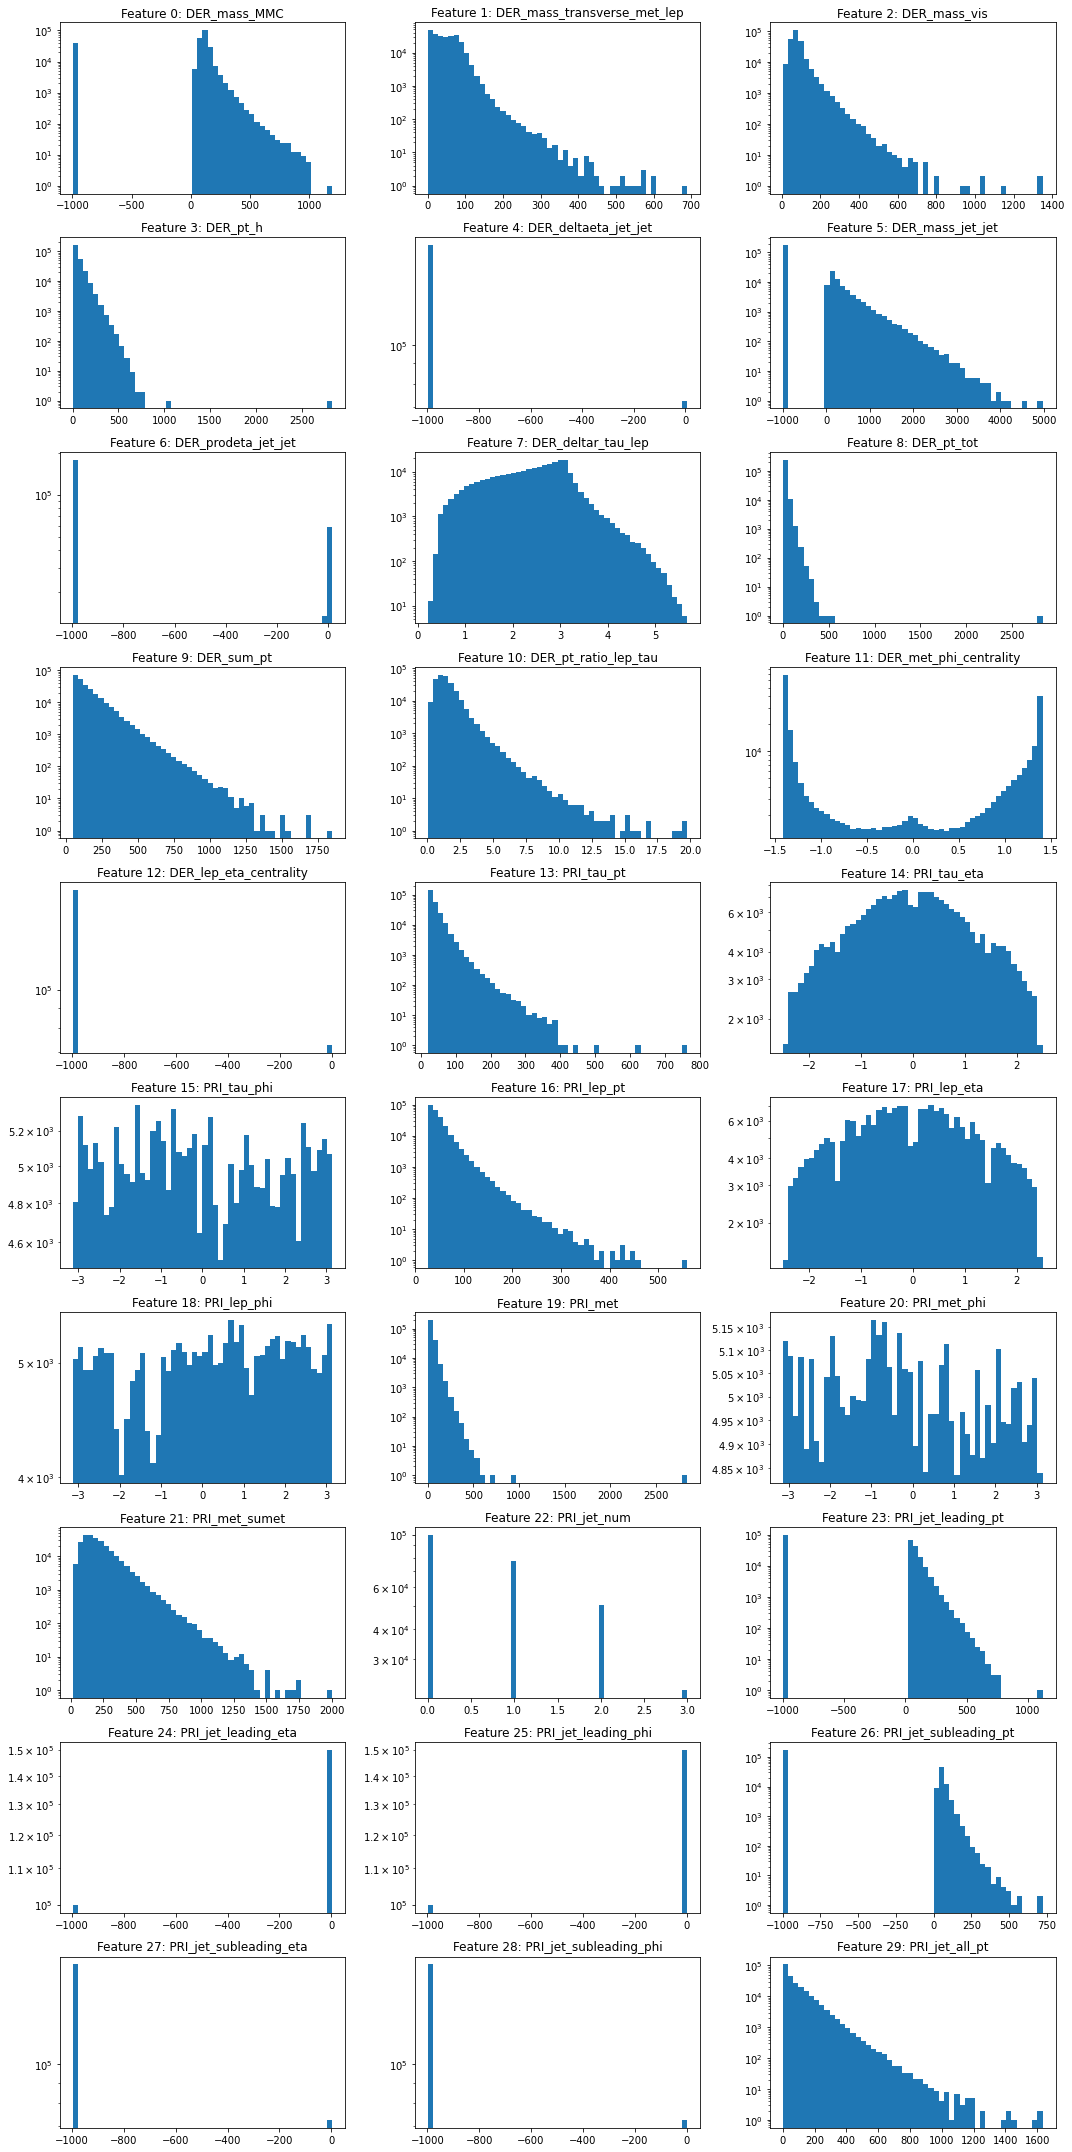

In [24]:
def plot_features_distrib(tX):
    plt.figure(figsize=(15,30))
    for i in range(tX.shape[1]):
        plt.subplot(10, 3, i+1)
        plt.hist(tX[:,i], bins=50)
        plt.yscale('log')
        plt.title("Feature {}: {}".format(i, features[i]))
    plt.tight_layout()
    plt.show()
plot_features_distrib(tX)

We can confirm what we suggested before, some features (such as 12, 26, 27, 28), mostly contains invalid values. Instead of simply removing them, we should have a look later to see if we could possibly extract some information out of them. 

We also see that the discrete features offer only a small amount of different values, it might be interesting to plot distributions while discriminating over those discrete values.

The continuous features offer a wide range of distributions, 15, 18 and 20 for example appear to be uniform distribution.

We should also check wether or not 21, 23, 29 are heavy tailed.

Some, such as 1 or 7, are bimodal distributions, we might get some insight while discriminating over the label.